In [1]:
import pandas as pd

import torch.nn as nn
import torch

import copy
import re
import networkx as nx
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import os
import numpy as np
from pickle import dump , load
import seaborn as sns
import re

In [2]:
class AdultClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(13, 64)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(64, 128)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(128, 32)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(32, 16)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.act1(self.hidden1(x)))
        x = self.dropout(self.act2(self.hidden2(x)))
        x = self.dropout(self.act3(self.hidden3(x)))
        x = self.dropout(self.act4(self.hidden4(x)))
        # x = self.output(x)
        x = self.act_output(self.output(x))
        return x
    
    
def load_model():
    model = torch.load('model_training/adult_credit__model')
    model.eval()
    return model



def load_scaler(scaler_loc):
    return load(open(scaler_loc, 'rb'))




def load_data(data):
    return np.load(data)

def apply_phenotype(array, phenotype):
    # Split the phenotype string into individual operations
    operations = phenotype.split(';')
    x = copy.deepcopy(array)
    # Iterate over each operation and execute it
    for operation in operations:
        # Strip any leading/trailing whitespace from the operation
        operation = operation.strip()
        
        # Use the exec function to execute the operation on the array
        if operation:
            exec(operation)

    return x

def combine_operations(phenotype, original_input):
    combined_operations = []
    processed_input = apply_phenotype(original_input, phenotype)
    change =  processed_input - original_input
    
    # print(change)
    for i, j  in enumerate(change):
        if j == 0:
            continue
        else:
            if j > 0:
                combined_operations.append(f'x[{i}] += {j}')
            else:
                combined_operations.append(f'x[{i}] -= {-j}')
                
    return '; '.join(combined_operations)

def extract_index(expression):
    # Use regular expression to find the number within the square brackets
    match = re.search(r'\[(\d+)\]', expression)
    if match:
        return match.group(1)
    else:
        return None


def permute_phenotype(phenotype):
    
    split_phenotype = [i.strip() for i in phenotype.split(";")]
    if len(split_phenotype) == 1:
        return None
    permute_dict = {}
    for i, j in enumerate(split_phenotype):
        split_phenotype_copy = copy.deepcopy(split_phenotype)
        key_string = split_phenotype_copy.pop(i)
        key = extract_index(key_string.strip())
        permute_dict[key] = '; '.join(split_phenotype_copy)
    return permute_dict


def eval_phenotype(model, input, scaler, columns_to_standardize):
    model.eval()
    # print(input)
    input = input.reshape(-1, 13)
    input = torch.tensor(input, dtype=torch.float32)
    input = input.numpy()
    input[:, columns_to_standardize] = scaler.transform(input[:, columns_to_standardize])
    input = torch.from_numpy(input).type(torch.float)
    with torch.no_grad():
        prob = model(input)
    if prob.tolist()[0][0] > 0.5:
        return 1
    else:
        return 0

def eval_model(model, input, scaler, columns_to_standardize):
    model.eval()
    # print(input)
    input = input.reshape(-1, 13)
    input = torch.tensor(input, dtype=torch.float32)
    input = input.numpy()
    input[:, columns_to_standardize] = scaler.transform(input[:, columns_to_standardize])
    input = torch.from_numpy(input).type(torch.float)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0][0]


def perturbation_effect(phenotype_list, model, input, features_index, scaler, columns_to_standardize):
    """
    number of failure signifies that how many times  after removing the feature, the
    phenotype still worked 
    """
    
    num_failure = {str(i) : 0 for i in range(features_index)}
    total = {str(i) : 0 for i in range(features_index)}
    for phenotype in phenotype_list:
        modified_input  = apply_phenotype(input, phenotype)
        phenotype_output_model = eval_model(model, modified_input, scaler, columns_to_standardize)
        if phenotype_output_model < 0.5:
            continue
        permute_dict = permute_phenotype(phenotype)
        print(permute_dict)
        if permute_dict is not None:
            # print(permute_dict)
            for key, value in permute_dict.items():
                input_evolved =  apply_phenotype(input, value)
                total[key] += 1
                num_failure[key] += eval_phenotype(model, input_evolved, scaler, columns_to_standardize)
    return num_failure, total
                

def phenotype_perturbation_analysis(input_folder, features, model, scaler, columns_to_standardize,  features_index=13):
    permutation_result = {}
    for i in os.listdir(input_folder):
        if i=='.DS_Store':
            continue
        filename = input_folder + '/' + i + '/' "final_gen.csv"
        input_array_location = input_folder + '/' + i + '/' + 'input_data.npy'
        input = load_data(input_array_location)
        model_out = eval_model(model, input, scaler, columns_to_standardize)
        data = pd.read_csv(filename)
        data = data.sort_values(by=['o_1'])
        # data = data[data['o_1'] < 0.45]
        data['combined_phenotype'] = data.apply(lambda row: combine_operations(row['Phenotype'], input), axis=1)
        num_failure, total = perturbation_effect(list(data['combined_phenotype']), model, input, features_index, scaler, columns_to_standardize)
        permutation_result[i] = (num_failure, total)
    return permutation_result
        


In [3]:
model = load_model()

input_folder = 'output/NSGAIII_multi'

features = ['age','workclass','fnlwgt','education-num','marital-status','occupation','relationship','race','sex',
            'capital-gain','capital-loss','hours-per-week','native-country']



model = load_model()
columns_to_standardize = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]
scaler = load_scaler(scaler_loc='model_training/StandardScaler.pkl')

permutation_result = phenotype_perturbation_analysis(input_folder, features, model, scaler, columns_to_standardize, features_index=13)

{'0': 'x[9] += 20000', '9': 'x[0] += 7'}
{'0': 'x[9] += 20000', '9': 'x[0] += 7'}
{'0': 'x[2] += 7000; x[9] += 12000', '2': 'x[0] += 7; x[9] += 12000', '9': 'x[0] += 7; x[2] += 7000'}
{'1': 'x[3] += 3; x[9] += 9000; x[10] += 2000', '3': 'x[1] -= 4; x[9] += 9000; x[10] += 2000', '9': 'x[1] -= 4; x[3] += 3; x[10] += 2000', '10': 'x[1] -= 4; x[3] += 3; x[9] += 9000'}
{'1': 'x[3] += 9; x[10] += 2000', '3': 'x[1] -= 4; x[10] += 2000', '10': 'x[1] -= 4; x[3] += 9'}
None
None
None
{'6': 'x[9] += 17000', '9': 'x[6] += 1'}
{'3': 'x[9] += 8000', '9': 'x[3] += 7'}
None
None
{'1': 'x[9] += 16000', '9': 'x[1] -= 2'}
None
{'9': 'x[11] -= 9', '11': 'x[9] += 9000'}
{'0': 'x[1] += 8; x[3] += 8; x[4] -= 3; x[5] += 7; x[10] += 2500', '1': 'x[0] += 8; x[3] += 8; x[4] -= 3; x[5] += 7; x[10] += 2500', '3': 'x[0] += 8; x[1] += 8; x[4] -= 3; x[5] += 7; x[10] += 2500', '4': 'x[0] += 8; x[1] += 8; x[3] += 8; x[5] += 7; x[10] += 2500', '5': 'x[0] += 8; x[1] += 8; x[3] += 8; x[4] -= 3; x[10] += 2500', '10': 'x[0]

In [4]:
permutation_result

{'20': ({'0': 3,
   '1': 0,
   '2': 1,
   '3': 0,
   '4': 0,
   '5': 0,
   '6': 0,
   '7': 0,
   '8': 0,
   '9': 0,
   '10': 0,
   '11': 0,
   '12': 0},
  {'0': 3,
   '1': 0,
   '2': 1,
   '3': 0,
   '4': 0,
   '5': 0,
   '6': 0,
   '7': 0,
   '8': 0,
   '9': 3,
   '10': 0,
   '11': 0,
   '12': 0}),
 '18': ({'0': 0,
   '1': 2,
   '2': 0,
   '3': 1,
   '4': 0,
   '5': 0,
   '6': 0,
   '7': 0,
   '8': 0,
   '9': 0,
   '10': 1,
   '11': 0,
   '12': 0},
  {'0': 0,
   '1': 2,
   '2': 0,
   '3': 2,
   '4': 0,
   '5': 0,
   '6': 0,
   '7': 0,
   '8': 0,
   '9': 1,
   '10': 2,
   '11': 0,
   '12': 0}),
 '27': ({'0': 0,
   '1': 0,
   '2': 0,
   '3': 0,
   '4': 0,
   '5': 0,
   '6': 1,
   '7': 0,
   '8': 0,
   '9': 0,
   '10': 0,
   '11': 0,
   '12': 0},
  {'0': 0,
   '1': 0,
   '2': 0,
   '3': 1,
   '4': 0,
   '5': 0,
   '6': 1,
   '7': 0,
   '8': 0,
   '9': 2,
   '10': 0,
   '11': 0,
   '12': 0}),
 '9': ({'0': 0,
   '1': 1,
   '2': 0,
   '3': 0,
   '4': 0,
   '5': 0,
   '6': 0,
   '7': 0,
   '

In [5]:
def add_dict_values(dict1, dict2):
    if dict1.keys() != dict2.keys():
        raise ValueError("Both dictionaries must have the same keys")

    result_dict = {}

    for key in dict1:
        result_dict[key] = dict1[key] + dict2[key]

    return result_dict



def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



success_dict = {str(i) : 0 for i in range(13)}
total_dict = {str(i) : 0 for i in range(13)}
for key, value in permutation_result.items():
    success_dict  =  add_dict_values(success_dict, value[0])
    total_dict  =  add_dict_values(total_dict, value[1])

In [6]:
success_dict, total_dict

({'0': 35,
  '1': 6,
  '2': 26,
  '3': 25,
  '4': 3,
  '5': 9,
  '6': 5,
  '7': 2,
  '8': 4,
  '9': 3,
  '10': 8,
  '11': 26,
  '12': 27},
 {'0': 61,
  '1': 12,
  '2': 26,
  '3': 92,
  '4': 9,
  '5': 11,
  '6': 23,
  '7': 7,
  '8': 5,
  '9': 100,
  '10': 14,
  '11': 33,
  '12': 28})

In [7]:
# percentage time the counterfactual fails if the feature change is removed.
features = ['age','workclass','fnlwgt','education-num','marital-status','occupation','relationship','race','sex',
            'capital-gain','capital-loss','hours-per-week','native-country']
percentage_dict = {}
percentage_dict_with_features = {}
for key, value in total_dict.items():
    percentage_dict[key] = 100 - success_dict[key]/total_dict[key] * 100
    percentage_dict_with_features[features[int(key)]] = 100 - success_dict[key]/total_dict[key] * 100
percentage_dict, percentage_dict_with_features

({'0': 42.622950819672134,
  '1': 50.0,
  '2': 0.0,
  '3': 72.82608695652175,
  '4': 66.66666666666667,
  '5': 18.181818181818173,
  '6': 78.26086956521739,
  '7': 71.42857142857143,
  '8': 20.0,
  '9': 97.0,
  '10': 42.85714285714286,
  '11': 21.212121212121218,
  '12': 3.5714285714285694},
 {'age': 42.622950819672134,
  'workclass': 50.0,
  'fnlwgt': 0.0,
  'education-num': 72.82608695652175,
  'marital-status': 66.66666666666667,
  'occupation': 18.181818181818173,
  'relationship': 78.26086956521739,
  'race': 71.42857142857143,
  'sex': 20.0,
  'capital-gain': 97.0,
  'capital-loss': 42.85714285714286,
  'hours-per-week': 21.212121212121218,
  'native-country': 3.5714285714285694})

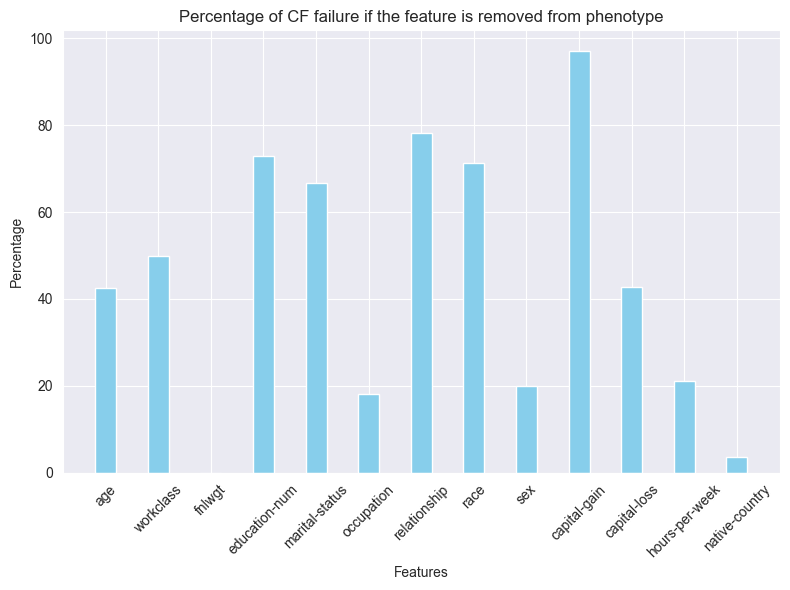

In [8]:
plot_bar_graph(percentage_dict_with_features, title="Percentage of CF failure if the feature is removed from phenotype", xlabel="Features", ylabel="Percentage")